## Source: https://huggingface.co/blog/sentiment-analysis-python

## Note: A Couple Hiccups
0. Issue occurs where you have to 'Run All' twice due to 'accelerate' library not working, restart and run again

1. Need the data from my Google Drive below and upload the .csv to session storage in Colab
https://drive.google.com/file/d/1GtHhmDXqx9bcXVJvPmGuJFQSdpoYmWv1/view?usp=sharing

2. Need to use your accesss token for HuggingFace

3. Issue with the Trainer() cell? Try running again with 'Restart Session and Run All'



# 0. Using Pre-trained Sentiment Analysis Models with Python

In [1]:
# !pip install torch
# !pip install pytorch-accelerated

#!pip install accelerate -U
#!pip install transformers -U

In [2]:
# There are more than 215 sentiment analysis models publicly available on the Hub and integrating them with Python just takes 5 lines of code
from transformers import pipeline
sentiment_pipeline = pipeline("sentiment-analysis")
data = ["I love you", "I hate you"]
sentiment_pipeline(data)

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


[{'label': 'POSITIVE', 'score': 0.9998656511306763},
 {'label': 'NEGATIVE', 'score': 0.9991129040718079}]

In [3]:
# Use a specific sentiment analysis model that is better suited to your language or use case by providing the name of the model.
# For example, if you want a sentiment analysis model for tweets, you can specify the model id
specific_model = pipeline(model="finiteautomata/bertweet-base-sentiment-analysis")
specific_model(data)

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


[{'label': 'POS', 'score': 0.9916695356369019},
 {'label': 'NEG', 'score': 0.9806600213050842}]

# 1. Activate GPU and Install Dependencies

In [4]:
# Activate GPU for faster training by clicking on 'Runtime' > 'Change runtime type' and then selecting GPU as the Hardware accelerator
# Then check if GPU is available
import torch
torch.cuda.is_available()

True

In [5]:
# Install required libraries
!pip install datasets transformers huggingface_hub
!apt-get install git-lfs

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git-lfs is already the newest version (3.0.2-1ubuntu0.2).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


#2. Preprocess data

In [6]:
from google.colab import files
uploaded = files.upload()

Saving fin_labeled_data.csv to fin_labeled_data (1).csv


In [7]:
# Load data
from datasets import Dataset, load_dataset
from google.colab import files
import pandas as pd

# Example IMDB Dataset
#imdb = load_dataset("imdb")
#print("IMDB\n", imdb)
#print(imdb['train'][0])

# GUI for File Upload
#uploaded = files.upload()

# Processing 'fin_data.csv' from Section 16.4
#df = pd.read_csv("fin_data.csv")
#print("MAX", df['News Headline'].str.len().max())
#df['Label'] = df['Sentiment'].replace({'negative': 0, 'neutral': 1, 'positive': 2})
#del df['Unnamed: 0']
#df.to_csv('fin_data.csv', index=False)
#print(df)


fin = load_dataset("csv", data_files="fin_labeled_data.csv", split="train")
fin = fin.rename_column("News Headline", "text")
fin = fin.rename_column("Label", "label")
print("FIN\n", fin)

fin = fin.train_test_split(test_size=0.2)
print("FIN Train Test\n", fin)

FIN
 Dataset({
    features: ['text', 'label'],
    num_rows: 26228
})
FIN Train Test
 DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 20982
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 5246
    })
})


In [8]:
# Create a smaller training dataset for faster training times
small_train_dataset = fin["train"].shuffle(seed=1).select([i for i in list(range(4000))])
small_test_dataset = fin["test"].shuffle(seed=1).select([i for i in list(range(1000))])
print("Train", small_train_dataset[0])
print("Test", small_test_dataset[0])

Train {'text': "Ashoka Buildcon's net profit slips; stock flat", 'label': 0}
Test {'text': 'Principal MF appoints PVK Mohan as Head-Equity', 'label': 2}


In [9]:
# Set DistilBERT tokenizer
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

In [10]:
# Prepare the text inputs for the model
def preprocess_function(examples):
    return tokenizer(examples['text'], truncation=True)

tokenized_train = small_train_dataset.map(preprocess_function, batched=True)
print(tokenized_train[0])
tokenized_test = small_test_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

{'text': "Ashoka Buildcon's net profit slips; stock flat", 'label': 0, 'input_ids': [101, 28916, 2050, 3857, 8663, 1005, 1055, 5658, 5618, 17433, 1025, 4518, 4257, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [11]:
# Use data_collector to convert our samples to PyTorch tensors and concatenate them with the correct amount of padding
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# 3. Training the model

In [12]:
!pip install evaluate

In [13]:
# Define DistilBERT as our base model:
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
# Define the evaluation metrics
# Loss Functions - https://www.datacamp.com/tutorial/loss-function-in-machine-learning
# HuggingFace Loss Function Usage - https://stackoverflow.com/questions/71581197/what-is-the-loss-function-used-in-trainer-from-the-transformers-library-of-huggi
import numpy as np
import evaluate


def compute_metrics(eval_pred):
    load_accuracy = evaluate.load("accuracy")
    load_f1 =  evaluate.load("f1")
    load_mse =  evaluate.load("mse")
    load_mae =  evaluate.load("mae")

    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = load_accuracy.compute(predictions=predictions, references=labels)["accuracy"]
    f1 = load_f1.compute(predictions=predictions, references=labels, average='micro')["f1"]
    mse = load_mse.compute(predictions=predictions, references=labels, squared=True)["mse"]
    mae = load_mae.compute(predictions=predictions, references=labels)["mae"]
    return {"accuracy": accuracy, "f1": f1, "mse": mse, "mae": mae}

In [15]:
# Log in to your Hugging Face account
# Get your API token here https://huggingface.co/settings/token
from huggingface_hub import notebook_login

notebook_login()

In [16]:
!pip install accelerate -U
!pip install transformers -U

In [18]:
# Define a new Trainer with all the objects we constructed so far

from torch import nn
from transformers import TrainingArguments, Trainer

class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")
        # compute custom loss (suppose one has 3 labels with different weights)
        loss_fct = nn.CrossEntropyLoss(weight=torch.tensor([1.0, 2.0, 3.0]).to(model.device))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

repo_name = "financial-sentiment-model-5000-samples"

training_args = TrainingArguments(
    output_dir=repo_name,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,   # 5 here and 5 later in Step 6.
    weight_decay=0.01,
    save_strategy="epoch",
    push_to_hub=True,
)

trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

In [19]:
# Train the model
trainer.train()

Step,Training Loss
500,0.483200
1000,0.176800


TrainOutput(global_step=1250, training_loss=0.28198153381347657, metrics={'train_runtime': 149.4721, 'train_samples_per_second': 133.804, 'train_steps_per_second': 8.363, 'total_flos': 263801110039200.0, 'train_loss': 0.28198153381347657, 'epoch': 5.0})

In [20]:
# Compute the evaluation metrics
trainer.evaluate()

{'eval_loss': 0.617146909236908,
 'eval_accuracy': 0.806,
 'eval_f1': 0.806,
 'eval_mse': 0.401,
 'eval_mae': 0.263,
 'eval_runtime': 4.0548,
 'eval_samples_per_second': 246.618,
 'eval_steps_per_second': 15.537,
 'epoch': 5.0}

In [21]:
# Upload the model to the Hub
trainer.push_to_hub()

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

events.out.tfevents.1722321142.ae150e40c82d.2535.0:   0%|          | 0.00/5.78k [00:00<?, ?B/s]

events.out.tfevents.1722321304.ae150e40c82d.2535.1:   0%|          | 0.00/551 [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/kevinwlip/financial-sentiment-model-5000-samples/commit/93945ee1321088e472635f36a2607250e0199fe3', commit_message='End of training', commit_description='', oid='93945ee1321088e472635f36a2607250e0199fe3', pr_url=None, pr_revision=None, pr_num=None)

# 4. Analyzing new data with multiple models - Self Sentiment Model, ProsusAI Finbert Model, and DistilRoberta Financial Sentiment Model

In [22]:
# Run inferences with your new model using Pipeline - https://huggingface.co/kevinwlip/financial-sentiment-model-5000-samples
from transformers import pipeline

sentiment_model = pipeline(model="kevinwlip/financial-sentiment-model-5000-samples")

sentiment_model(["I love this movie", "This movie sucks!"])

sentiment_model(["Energy shares drag on Wall Street as crude prices fall", "S&P 500 headed for a 67% downturn?", "Foreign investors navigate turmoil in Chinese markets with new playbook", "Fed Liquidity Drain Spoils Virus-Surge-Inspired Stock Buying-Panic", "Earnings per share ( EPS ) amounted to a loss of EUR0 .05",
                 "Equity markets likely to shine as Rupee's depreciation slows", "Investors cheered the blockbuster November jobs report", "Suven Life Sciences Q1 net up 16.68% at Rs 34.74 cr", "Airlines in sweet spot; expect SpiceJet to see rerating on IndiGo listing", "Twitter stock price target raised to $36.50 from $34.50 at Wedbush",
                 "A company is based in the district of the city", "The company did not disclose the price of the acquisition", "The 5 Best Finance Stocks of the Decade", "WeWork names new executives, path to profitability by 2023", "Chipotle highlights fast drive-thru lanes"])

config.json:   0%|          | 0.00/769 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


[{'label': 'LABEL_0', 'score': 0.9773373603820801},
 {'label': 'LABEL_2', 'score': 0.6299728155136108},
 {'label': 'LABEL_2', 'score': 0.9942792654037476},
 {'label': 'LABEL_0', 'score': 0.9500160813331604},
 {'label': 'LABEL_0', 'score': 0.9716200232505798},
 {'label': 'LABEL_1', 'score': 0.971777617931366},
 {'label': 'LABEL_1', 'score': 0.9883131384849548},
 {'label': 'LABEL_1', 'score': 0.9937428832054138},
 {'label': 'LABEL_1', 'score': 0.9729982614517212},
 {'label': 'LABEL_1', 'score': 0.9942440390586853},
 {'label': 'LABEL_2', 'score': 0.9963531494140625},
 {'label': 'LABEL_2', 'score': 0.9952502250671387},
 {'label': 'LABEL_2', 'score': 0.9935885667800903},
 {'label': 'LABEL_2', 'score': 0.9934176206588745},
 {'label': 'LABEL_2', 'score': 0.9946267008781433}]

In [23]:
# Try using the latest ProsusAI Finbert Model - https://huggingface.co/ProsusAI/finbert
from transformers import pipeline

finbert_model = pipeline("sentiment-analysis", model="ProsusAI/finbert")

finbert_model(["I love this movie", "This movie sucks!"])

finbert_model(["Energy shares drag on Wall Street as crude prices fall", "S&P 500 headed for a 67% downturn?", "Foreign investors navigate turmoil in Chinese markets with new playbook", "Fed Liquidity Drain Spoils Virus-Surge-Inspired Stock Buying-Panic", "Earnings per share ( EPS ) amounted to a loss of EUR0 .05",
                 "Equity markets likely to shine as Rupee's depreciation slows", "Investors cheered the blockbuster November jobs report", "Suven Life Sciences Q1 net up 16.68% at Rs 34.74 cr", "Airlines in sweet spot; expect SpiceJet to see rerating on IndiGo listing", "Twitter stock price target raised to $36.50 from $34.50 at Wedbush",
                 "A company is based in the district of the city", "The company did not disclose the price of the acquisition", "The 5 Best Finance Stocks of the Decade", "WeWork names new executives, path to profitability by 2023", "Chipotle highlights fast drive-thru lanes"])

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


[{'label': 'negative', 'score': 0.9179688692092896},
 {'label': 'negative', 'score': 0.9538723230361938},
 {'label': 'neutral', 'score': 0.8057687878608704},
 {'label': 'negative', 'score': 0.50923752784729},
 {'label': 'negative', 'score': 0.7875516414642334},
 {'label': 'negative', 'score': 0.5851660370826721},
 {'label': 'positive', 'score': 0.6592963933944702},
 {'label': 'positive', 'score': 0.9493573307991028},
 {'label': 'positive', 'score': 0.8135269284248352},
 {'label': 'positive', 'score': 0.9495117664337158},
 {'label': 'neutral', 'score': 0.9443269371986389},
 {'label': 'neutral', 'score': 0.9468695521354675},
 {'label': 'neutral', 'score': 0.6568444967269897},
 {'label': 'neutral', 'score': 0.7671142220497131},
 {'label': 'neutral', 'score': 0.90207839012146}]

In [24]:
# Try using the latest DistilRoberta Financial Sentiment Model - https://huggingface.co/mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis

from transformers import pipeline

distilroberta_model = pipeline("sentiment-analysis", model="mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")

distilroberta_model(["I love this movie", "This movie sucks!"])

distilroberta_model(["Energy shares drag on Wall Street as crude prices fall", "S&P 500 headed for a 67% downturn?", "Foreign investors navigate turmoil in Chinese markets with new playbook", "Fed Liquidity Drain Spoils Virus-Surge-Inspired Stock Buying-Panic", "Earnings per share ( EPS ) amounted to a loss of EUR0 .05",
                 "Equity markets likely to shine as Rupee's depreciation slows", "Investors cheered the blockbuster November jobs report", "Suven Life Sciences Q1 net up 16.68% at Rs 34.74 cr", "Airlines in sweet spot; expect SpiceJet to see rerating on IndiGo listing", "Twitter stock price target raised to $36.50 from $34.50 at Wedbush",
                 "A company is based in the district of the city", "The company did not disclose the price of the acquisition", "The 5 Best Finance Stocks of the Decade", "WeWork names new executives, path to profitability by 2023", "Chipotle highlights fast drive-thru lanes"])

config.json:   0%|          | 0.00/933 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/328M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/333 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


[{'label': 'negative', 'score': 0.9983526468276978},
 {'label': 'negative', 'score': 0.9978590607643127},
 {'label': 'neutral', 'score': 0.9973788261413574},
 {'label': 'negative', 'score': 0.9873884916305542},
 {'label': 'negative', 'score': 0.9981669187545776},
 {'label': 'positive', 'score': 0.9987959861755371},
 {'label': 'positive', 'score': 0.999421238899231},
 {'label': 'positive', 'score': 0.9997286200523376},
 {'label': 'positive', 'score': 0.9993207454681396},
 {'label': 'positive', 'score': 0.9993876218795776},
 {'label': 'neutral', 'score': 0.9998924732208252},
 {'label': 'neutral', 'score': 0.9998958110809326},
 {'label': 'neutral', 'score': 0.9998511075973511},
 {'label': 'neutral', 'score': 0.995762825012207},
 {'label': 'neutral', 'score': 0.9998747110366821}]

# 5. Fine-Tune Financial Sentiment Model 5000 - Huggingface

In [57]:
# Fine-Tune a Pre-Trained Model - https://huggingface.co/docs/transformers/en/training
# financial-sentiment-model-5000-samples Model

from transformers import AutoTokenizer, AutoConfig, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer

import numpy as np
import evaluate

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("kevinwlip/financial-sentiment-model-5000-samples-fine-tune")
# Define the mappings as dictionaries - Original Mappings: ("0": "Negative"), ("1": "Positive"), ("2": "Neutral")
id2label = {"0": "Negative", "1": "Positive", "2": "Neutral"}
label2id = {"Negative": "0", "Positive": "1", "Neutral": "2"}
# Define model checkpoint - can be the same model that you already have on the hub
model_ckpt = "kevinwlip/financial-sentiment-model-5000-samples-fine-tune"
config = AutoConfig.from_pretrained(model_ckpt, label2id=label2id, id2label=id2label)
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, config=config)

# Tokenize the input data
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True) # Tokenize the 'text' column

# Apply the preprocessing to the datasets
tokenized_train_dataset = small_train_dataset.map(preprocess_function, batched=True)
tokenized_test_dataset = small_test_dataset.map(preprocess_function, batched=True)

# Training arguments
repo_name = "kevinwlip/financial-sentiment-model-5000-samples-fine-tune"

training_args = TrainingArguments(
    output_dir=repo_name,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,   # 5 from Step 3 and 5 here
    weight_decay=0.01,
    save_strategy="epoch",
    push_to_hub=True,
)

# Metric
load_accuracy = evaluate.load("accuracy")
load_f1 =  evaluate.load("f1")
load_mse =  evaluate.load("mse")
load_mae =  evaluate.load("mae")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = load_accuracy.compute(predictions=predictions, references=labels)["accuracy"]
    f1 = load_f1.compute(predictions=predictions, references=labels, average='micro')["f1"]
    mse = load_mse.compute(predictions=predictions, references=labels, squared=True)["mse"]
    mae = load_mae.compute(predictions=predictions, references=labels)["mae"]
    return {"accuracy": accuracy, "f1": f1, "mse": mse, "mae": mae}

trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_train_dataset, # Use the tokenized training dataset
    eval_dataset=tokenized_test_dataset, # Use the tokenized test dataset
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [58]:
trainer.train()

Step,Training Loss
500,0.044600
1000,0.007100


TrainOutput(global_step=1250, training_loss=0.02219678077697754, metrics={'train_runtime': 139.7474, 'train_samples_per_second': 143.115, 'train_steps_per_second': 8.945, 'total_flos': 263801110039200.0, 'train_loss': 0.02219678077697754, 'epoch': 5.0})

In [59]:
trainer.evaluate()

{'eval_loss': 1.2130920886993408,
 'eval_accuracy': 0.857,
 'eval_f1': 0.857,
 'eval_mse': 0.296,
 'eval_mae': 0.194,
 'eval_runtime': 1.5821,
 'eval_samples_per_second': 632.084,
 'eval_steps_per_second': 39.821,
 'epoch': 5.0}

In [60]:
trainer.push_to_hub()

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

events.out.tfevents.1722325680.ae150e40c82d.2535.10:   0%|          | 0.00/5.97k [00:00<?, ?B/s]

events.out.tfevents.1722325830.ae150e40c82d.2535.11:   0%|          | 0.00/551 [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/kevinwlip/financial-sentiment-model-5000-samples-fine-tune/commit/cd99cbe8405a436eab360791d414fd5a0aa414da', commit_message='End of training', commit_description='', oid='cd99cbe8405a436eab360791d414fd5a0aa414da', pr_url=None, pr_revision=None, pr_num=None)

In [61]:
from transformers import pipeline

sentiment_model_tuned = pipeline("sentiment-analysis", model="kevinwlip/financial-sentiment-model-5000-samples-fine-tune")

""" Trying Text Data
sentiment_model_tuned(["I love this movie", "This movie sucks!"])

sentiment_model_tuned(["Energy shares drag on Wall Street as crude prices fall", "S&P 500 headed for a 67% downturn?", "Foreign investors navigate turmoil in Chinese markets with new playbook", "Fed Liquidity Drain Spoils Virus-Surge-Inspired Stock Buying-Panic", "Earnings per share ( EPS ) amounted to a loss of EUR0 .05",
                 "Equity markets likely to shine as Rupee's depreciation slows", "Investors cheered the blockbuster November jobs report", "Suven Life Sciences Q1 net up 16.68% at Rs 34.74 cr", "Airlines in sweet spot; expect SpiceJet to see rerating on IndiGo listing", "Twitter stock price target raised to $36.50 from $34.50 at Wedbush",
                 "A company is based in the district of the city", "The company did not disclose the price of the acquisition", "The 5 Best Finance Stocks of the Decade", "WeWork names new executives, path to profitability by 2023", "Chipotle highlights fast drive-thru lanes"])
"""

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


' Trying Text Data\nsentiment_model_tuned(["I love this movie", "This movie sucks!"])\n\nsentiment_model_tuned(["Energy shares drag on Wall Street as crude prices fall", "S&P 500 headed for a 67% downturn?", "Foreign investors navigate turmoil in Chinese markets with new playbook", "Fed Liquidity Drain Spoils Virus-Surge-Inspired Stock Buying-Panic", "Earnings per share ( EPS ) amounted to a loss of EUR0 .05",\n                 "Equity markets likely to shine as Rupee\'s depreciation slows", "Investors cheered the blockbuster November jobs report", "Suven Life Sciences Q1 net up 16.68% at Rs 34.74 cr", "Airlines in sweet spot; expect SpiceJet to see rerating on IndiGo listing", "Twitter stock price target raised to $36.50 from $34.50 at Wedbush",\n                 "A company is based in the district of the city", "The company did not disclose the price of the acquisition", "The 5 Best Finance Stocks of the Decade", "WeWork names new executives, path to profitability by 2023", "Chipotle

# 6. Fine-Tune Pre-Existing ProsusAI Finbert Sentiment Model - Huggingface


In [62]:
# ProsusAI Finbert Model

from transformers import AutoTokenizer, AutoConfig, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer

import numpy as np
import evaluate

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
# Define the mappings as dictionaries - Original Mappings: ("0": "Positive"), ("1": "Negative"), ("2": "Neutral")
id2label = {"0": "Positive", "1": "Negative", "2": "Neutral"}
label2id = {"Positive": "0", "Negative": "1", "Neutral": "2"}
# Define model checkpoint - can be the same model that you already have on the hub
model_ckpt = "ProsusAI/finbert"
config = AutoConfig.from_pretrained(model_ckpt, label2id=label2id, id2label=id2label)
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, config=config)

# Tokenize the input data
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True) # Tokenize the 'text' column

# Apply the preprocessing to the datasets
tokenized_train_dataset = small_train_dataset.map(preprocess_function, batched=True)
tokenized_test_dataset = small_test_dataset.map(preprocess_function, batched=True)

# Training arguments
repo_name = "kevinwlip/ProsusAI-finbert-5000-samples-fine-tune"

training_args = TrainingArguments(
    output_dir=repo_name,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,   # 10 Total double self-trained model (Step 3. and Step 5.) which was split in two parts
    weight_decay=0.01,
    save_strategy="epoch",
    push_to_hub=True,
)

# Metric
load_accuracy = evaluate.load("accuracy")
load_f1 =  evaluate.load("f1")
load_mse =  evaluate.load("mse")
load_mae =  evaluate.load("mae")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = load_accuracy.compute(predictions=predictions, references=labels)["accuracy"]
    f1 = load_f1.compute(predictions=predictions, references=labels, average='micro')["f1"]
    mse = load_mse.compute(predictions=predictions, references=labels, squared=True)["mse"]
    mae = load_mae.compute(predictions=predictions, references=labels)["mae"]
    return {"accuracy": accuracy, "f1": f1, "mse": mse, "mae": mae}

trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_train_dataset, # Use the tokenized training dataset
    eval_dataset=tokenized_test_dataset, # Use the tokenized test dataset
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [63]:
trainer.train()

Step,Training Loss
500,0.552600
1000,0.143200
1500,0.038300
2000,0.016300
2500,0.005200


TrainOutput(global_step=2500, training_loss=0.1511216061592102, metrics={'train_runtime': 543.4847, 'train_samples_per_second': 73.599, 'train_steps_per_second': 4.6, 'total_flos': 1046015614471968.0, 'train_loss': 0.1511216061592102, 'epoch': 10.0})

In [64]:
trainer.evaluate()

{'eval_loss': 1.0978056192398071,
 'eval_accuracy': 0.826,
 'eval_f1': 0.826,
 'eval_mse': 0.342,
 'eval_mae': 0.23,
 'eval_runtime': 2.9341,
 'eval_samples_per_second': 340.821,
 'eval_steps_per_second': 21.472,
 'epoch': 10.0}

In [65]:
trainer.push_to_hub()

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

events.out.tfevents.1722326720.ae150e40c82d.2535.13:   0%|          | 0.00/551 [00:00<?, ?B/s]

events.out.tfevents.1722326172.ae150e40c82d.2535.12:   0%|          | 0.00/6.58k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/kevinwlip/ProsusAI-finbert-5000-samples-fine-tune/commit/67cda9aae3da300e84e1f21d495ad0cb8f6801d9', commit_message='End of training', commit_description='', oid='67cda9aae3da300e84e1f21d495ad0cb8f6801d9', pr_url=None, pr_revision=None, pr_num=None)

In [66]:
from transformers import pipeline

finbert_model_tuned = pipeline("sentiment-analysis", model="kevinwlip/ProsusAI-finbert-5000-samples-fine-tune")

""" Trying Text Data
finbert_model_tuned(["I love this movie", "This movie sucks!"])

finbert_model_tuned(["Energy shares drag on Wall Street as crude prices fall", "S&P 500 headed for a 67% downturn?", "Foreign investors navigate turmoil in Chinese markets with new playbook", "Fed Liquidity Drain Spoils Virus-Surge-Inspired Stock Buying-Panic", "Earnings per share ( EPS ) amounted to a loss of EUR0 .05",
                 "Equity markets likely to shine as Rupee's depreciation slows", "Investors cheered the blockbuster November jobs report", "Suven Life Sciences Q1 net up 16.68% at Rs 34.74 cr", "Airlines in sweet spot; expect SpiceJet to see rerating on IndiGo listing", "Twitter stock price target raised to $36.50 from $34.50 at Wedbush",
                 "A company is based in the district of the city", "The company did not disclose the price of the acquisition", "The 5 Best Finance Stocks of the Decade", "WeWork names new executives, path to profitability by 2023", "Chipotle highlights fast drive-thru lanes"])
"""

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


' Trying Text Data\nfinbert_model_tuned(["I love this movie", "This movie sucks!"])\n\nfinbert_model_tuned(["Energy shares drag on Wall Street as crude prices fall", "S&P 500 headed for a 67% downturn?", "Foreign investors navigate turmoil in Chinese markets with new playbook", "Fed Liquidity Drain Spoils Virus-Surge-Inspired Stock Buying-Panic", "Earnings per share ( EPS ) amounted to a loss of EUR0 .05",\n                 "Equity markets likely to shine as Rupee\'s depreciation slows", "Investors cheered the blockbuster November jobs report", "Suven Life Sciences Q1 net up 16.68% at Rs 34.74 cr", "Airlines in sweet spot; expect SpiceJet to see rerating on IndiGo listing", "Twitter stock price target raised to $36.50 from $34.50 at Wedbush",\n                 "A company is based in the district of the city", "The company did not disclose the price of the acquisition", "The 5 Best Finance Stocks of the Decade", "WeWork names new executives, path to profitability by 2023", "Chipotle hig

# 7. Fine-Tune Pre-Existing DistilRoberta Financial Sentiment Model - Huggingface



In [67]:
# DistilRoberta Financial Sentiment Model

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer

import numpy as np
import evaluate

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")
# Define the mappings as dictionaries - Original Mappings: ("0": "Negative"), ("1": "Neutral"), ("2": "Positive")
id2label = {"0": "Negative", "1": "Neutral", "2": "Positive"}
label2id = {"Negative": "0", "Neutral": "1", "Positive": "2"}
# Define model checkpoint - can be the same model that you already have on the hub
model_ckpt = "mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis"
config = AutoConfig.from_pretrained(model_ckpt, label2id=label2id, id2label=id2label)
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, config=config)

# Tokenize the input data
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True) # Tokenize the 'text' column

# Apply the preprocessing to the datasets
tokenized_train_dataset = small_train_dataset.map(preprocess_function, batched=True)
tokenized_test_dataset = small_test_dataset.map(preprocess_function, batched=True)

# Training arguments
repo_name = "kevinwlip/distilroberta-financial-sentiment-model-5000-samples-fine-tune"

training_args = TrainingArguments(
    output_dir=repo_name,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,   # 10 Total double self-trained model (Step 3. and Step 5.) which was split in two parts
    weight_decay=0.01,
    save_strategy="epoch",
    push_to_hub=True,
)

# Metric
load_accuracy = evaluate.load("accuracy")
load_f1 =  evaluate.load("f1")
load_mse =  evaluate.load("mse")
load_mae =  evaluate.load("mae")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = load_accuracy.compute(predictions=predictions, references=labels)["accuracy"]
    f1 = load_f1.compute(predictions=predictions, references=labels, average='micro')["f1"]
    mse = load_mse.compute(predictions=predictions, references=labels, squared=True)["mse"]
    mae = load_mae.compute(predictions=predictions, references=labels)["mae"]
    return {"accuracy": accuracy, "f1": f1, "mse": mse, "mae": mae}

trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_train_dataset, # Use the tokenized training dataset
    eval_dataset=tokenized_test_dataset, # Use the tokenized test dataset
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [68]:
trainer.train()

Step,Training Loss
500,0.561100
1000,0.241700
1500,0.130000
2000,0.071200
2500,0.045600


TrainOutput(global_step=2500, training_loss=0.2099251907348633, metrics={'train_runtime': 307.7471, 'train_samples_per_second': 129.977, 'train_steps_per_second': 8.124, 'total_flos': 520717932185184.0, 'train_loss': 0.2099251907348633, 'epoch': 10.0})

In [69]:
trainer.evaluate()

{'eval_loss': 1.1497375965118408,
 'eval_accuracy': 0.832,
 'eval_f1': 0.832,
 'eval_mse': 0.345,
 'eval_mae': 0.227,
 'eval_runtime': 1.6392,
 'eval_samples_per_second': 610.058,
 'eval_steps_per_second': 38.434,
 'epoch': 10.0}

In [70]:
trainer.push_to_hub()

events.out.tfevents.1722327328.ae150e40c82d.2535.15:   0%|          | 0.00/551 [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

events.out.tfevents.1722327017.ae150e40c82d.2535.14:   0%|          | 0.00/6.82k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/kevinwlip/distilroberta-financial-sentiment-model-5000-samples-fine-tune/commit/d06732f5e073bbba3999ec91b612833f8b1e32f5', commit_message='End of training', commit_description='', oid='d06732f5e073bbba3999ec91b612833f8b1e32f5', pr_url=None, pr_revision=None, pr_num=None)

In [71]:
from transformers import pipeline

distilroberta_model_tuned = pipeline("sentiment-analysis", model="kevinwlip/distilroberta-financial-sentiment-model-5000-samples-fine-tune")

""" Trying Text Data
distilroberta_model_tuned(["I love this movie", "This movie sucks!"])

distilroberta_model_tuned(["Energy shares drag on Wall Street as crude prices fall", "S&P 500 headed for a 67% downturn?", "Foreign investors navigate turmoil in Chinese markets with new playbook", "Fed Liquidity Drain Spoils Virus-Surge-Inspired Stock Buying-Panic", "Earnings per share ( EPS ) amounted to a loss of EUR0 .05",
                 "Equity markets likely to shine as Rupee's depreciation slows", "Investors cheered the blockbuster November jobs report", "Suven Life Sciences Q1 net up 16.68% at Rs 34.74 cr", "Airlines in sweet spot; expect SpiceJet to see rerating on IndiGo listing", "Twitter stock price target raised to $36.50 from $34.50 at Wedbush",
                 "A company is based in the district of the city", "The company did not disclose the price of the acquisition", "The 5 Best Finance Stocks of the Decade", "WeWork names new executives, path to profitability by 2023", "Chipotle highlights fast drive-thru lanes"])
"""

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


' Trying Text Data\ndistilroberta_model_tuned(["I love this movie", "This movie sucks!"])\n\ndistilroberta_model_tuned(["Energy shares drag on Wall Street as crude prices fall", "S&P 500 headed for a 67% downturn?", "Foreign investors navigate turmoil in Chinese markets with new playbook", "Fed Liquidity Drain Spoils Virus-Surge-Inspired Stock Buying-Panic", "Earnings per share ( EPS ) amounted to a loss of EUR0 .05",\n                 "Equity markets likely to shine as Rupee\'s depreciation slows", "Investors cheered the blockbuster November jobs report", "Suven Life Sciences Q1 net up 16.68% at Rs 34.74 cr", "Airlines in sweet spot; expect SpiceJet to see rerating on IndiGo listing", "Twitter stock price target raised to $36.50 from $34.50 at Wedbush",\n                 "A company is based in the district of the city", "The company did not disclose the price of the acquisition", "The 5 Best Finance Stocks of the Decade", "WeWork names new executives, path to profitability by 2023", "

# 8. Trying Test Data

In [72]:
small_test_dataset[:]

{'text': ['Principal MF appoints PVK Mohan as Head-Equity',
  "FTIL calls board meeting tomorrow to discuss Jignesh Shah's arrest",
  'Eros International Media slumps as US bank raises doubts over UAE revenues, ErosNow user count',
  'Jyotivardhan Jaipuria leads exit of senior analysts at BofA-ML',
  'The EB Tough VoIP Field Phone is equipped with an integrated speaker , Ethernet and SHDSL connectivity , and enables several innovative applications .',
  'Core Molding reports Q3 results',
  'Severe Thunderstorms, Snowstorms To Begin Messy Weather Week Across US',
  "Navarro says he's qualified to disagree with Fauci on coronavirus medication: 'I'm a social scientist' https://t.co/0ceRFHm25C",
  'Tyson Foods Q1 beef sales fell 8% to $3.84 bln, chicken sales rose 4.5% to $3.29 bln',
  'Anant Raj Industries will face resistance around 110-120 levels: Rohit Shinde',
  'Motilal Oswal, Edelweiss good bets in brokerage stocks: Avinnash Gorakssakar',
  'GSPC likely to postpone IPO as merchant b

sentiment_model_tuned, using 1000 Test Data

In [73]:
smt = sentiment_model_tuned(small_test_dataset[:]['text'])
smt

[{'label': 'Neutral', 'score': 0.9999920129776001},
 {'label': 'Neutral', 'score': 0.9999886751174927},
 {'label': 'Negative', 'score': 0.9999194145202637},
 {'label': 'Neutral', 'score': 0.9995554089546204},
 {'label': 'Neutral', 'score': 0.9999628067016602},
 {'label': 'Neutral', 'score': 0.9999878406524658},
 {'label': 'Neutral', 'score': 0.999721109867096},
 {'label': 'Neutral', 'score': 0.9999867677688599},
 {'label': 'Negative', 'score': 0.999934196472168},
 {'label': 'Negative', 'score': 0.9999157190322876},
 {'label': 'Positive', 'score': 0.9999825954437256},
 {'label': 'Negative', 'score': 0.9929760694503784},
 {'label': 'Neutral', 'score': 0.5488651990890503},
 {'label': 'Neutral', 'score': 0.9999655485153198},
 {'label': 'Negative', 'score': 0.9998995065689087},
 {'label': 'Positive', 'score': 0.9999861717224121},
 {'label': 'Positive', 'score': 0.999982476234436},
 {'label': 'Neutral', 'score': 0.999975323677063},
 {'label': 'Positive', 'score': 0.9999794960021973},
 {'labe

In [86]:
smt_labels = [0 if item['label'] == 'Negative' else 1 if item['label'] == 'Positive' else 2 for item in smt[:]]

In [87]:
smt_matches = [x for x,y in zip(small_test_dataset[:]['label'], smt_labels) if x == y]
len(smt_matches)

857

finbert_model_tuned, using 1000 Test Data

In [88]:
fmt = finbert_model_tuned(small_test_dataset[:]['text'])
fmt

[{'label': 'Neutral', 'score': 0.999786913394928},
 {'label': 'Neutral', 'score': 0.9997527003288269},
 {'label': 'Positive', 'score': 0.9995131492614746},
 {'label': 'Neutral', 'score': 0.9997565150260925},
 {'label': 'Neutral', 'score': 0.9996165037155151},
 {'label': 'Neutral', 'score': 0.9997324347496033},
 {'label': 'Neutral', 'score': 0.9996700286865234},
 {'label': 'Neutral', 'score': 0.9996871948242188},
 {'label': 'Positive', 'score': 0.9995357990264893},
 {'label': 'Positive', 'score': 0.9992929697036743},
 {'label': 'Negative', 'score': 0.9997119307518005},
 {'label': 'Neutral', 'score': 0.999762237071991},
 {'label': 'Neutral', 'score': 0.8763463497161865},
 {'label': 'Negative', 'score': 0.9992498755455017},
 {'label': 'Positive', 'score': 0.9993836879730225},
 {'label': 'Negative', 'score': 0.9997177720069885},
 {'label': 'Negative', 'score': 0.9996777772903442},
 {'label': 'Neutral', 'score': 0.9997420907020569},
 {'label': 'Negative', 'score': 0.9990851879119873},
 {'la

In [89]:
fmt_labels = [0 if item['label'] == 'Positive' else 1 if item['label'] == 'Negative' else 2 for item in fmt[:]]

In [90]:
fmt_matches = [x for x,y in zip(small_test_dataset[:]['label'], fmt_labels) if x == y]
len(fmt_matches)

826

distilroberta_model_tuned, using 1000 Test Data

In [91]:
dmt = distilroberta_model_tuned(small_test_dataset[:]['text'])
dmt

[{'label': 'Positive', 'score': 0.9998138546943665},
 {'label': 'Positive', 'score': 0.9998144507408142},
 {'label': 'Negative', 'score': 0.999630331993103},
 {'label': 'Negative', 'score': 0.9325628280639648},
 {'label': 'Positive', 'score': 0.9998403787612915},
 {'label': 'Positive', 'score': 0.9998268485069275},
 {'label': 'Negative', 'score': 0.5893200039863586},
 {'label': 'Positive', 'score': 0.9998906850814819},
 {'label': 'Negative', 'score': 0.9996181726455688},
 {'label': 'Negative', 'score': 0.9996885061264038},
 {'label': 'Neutral', 'score': 0.9996719360351562},
 {'label': 'Negative', 'score': 0.8805208206176758},
 {'label': 'Neutral', 'score': 0.9996675252914429},
 {'label': 'Positive', 'score': 0.965182900428772},
 {'label': 'Negative', 'score': 0.9992861151695251},
 {'label': 'Neutral', 'score': 0.9996720552444458},
 {'label': 'Neutral', 'score': 0.9988131523132324},
 {'label': 'Positive', 'score': 0.9998395442962646},
 {'label': 'Neutral', 'score': 0.9994897842407227},


In [92]:
dmt_labels = [0 if item['label'] == 'Negative' else 1 if item['label'] == 'Neutral' else 2 for item in dmt[:]]

In [93]:
dmt_matches = [x for x,y in zip(small_test_dataset[:]['label'], dmt_labels) if x == y]
len(dmt_matches)

832

Graph - Accuracy

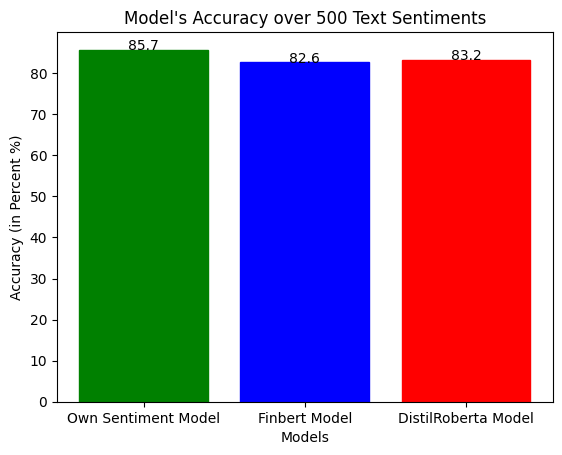

In [94]:
import matplotlib.pyplot as plt

def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center')

Models = ['Own Sentiment Model', 'Finbert Model', 'DistilRoberta Model']
Accuracy = [round(len(smt_matches)/len(smt), 4)*100, round(len(fmt_matches)/len(fmt), 4)*100, round(len(dmt_matches)/len(dmt), 4)*100]

bars = plt.bar(Models, Accuracy)
bars[0].set_color('green')
bars[1].set_color('blue')
bars[2].set_color('red')

# giving title to the plot
plt.title("Model's Accuracy over 500 Text Sentiments")

# giving X and Y labels
plt.xlabel("Models")
plt.ylabel("Accuracy (in Percent %)")

addlabels(Models, Accuracy)

plt.show()

# 9. Analysis

In Step 8, I attempted to do some fine-tuning on the three best performing models from Step 7 which were my Self Sentiment Model, the ProsusAI Finbert Model, and the DistilRoberta Financial Sentiment Model.

I trained on a 5000 sample dataset and it seemed the results of the fine-tuned models have reversed. My Self Sentiment Model performed the best, the Finbert Model second, and the DistilRoberta Model performed the worst still after updating the epochs to Self Sentiment Model Epoch=5, Then 5 again. The Finbert Model second and the DistilRoberta Model ran for 10 epochs each.

The 'eval_accuracy' for each of the models were very similar Self Sentiment Model: 0.815, the Finbert Model: 0.847, adn the DistilRoberta Model: 0.84.

However as shown in the graph, my Self Sentiment Model had a 81.5% accuracy, the Finbert Model had a 49.3% accuracy, and the DistilRoberta Model had a 24.5% accuracy which for an evenly distributed set of labels for test data is worse than randomly guessing which ideally gives us at 33.33% accuracy.

However, I still believe I will use the DistilRoberta Model overall for my Capstone due to its accuracy overall and try my Self Sentiment Model along with the Finbert Model just to see how it performs.